In [1]:
from folium.plugins import MeasureControl, FloatImage
import ipywidgets
import ipyleaflet
import subprocess
import geopandas as gpd
import pandas as pd
import altair as alt
import numpy as np
import shapely
import pyproj
import folium
import branca
import base64
import math
import json
import copy
import sys
import os
import io

In [2]:
print(f"ipywidgets version: {ipywidgets.__version__}")
print(f"ipyleaflet version: {ipyleaflet.__version__}")
print(f"folium version: {folium.__version__}")
#print(f"GDAL version: {gdal.__version__}")
print(f"python version:{sys.version[:6]}")

ipywidgets version: 8.1.7
ipyleaflet version: 0.20.0
folium version: 0.20.0
python version:3.11.1


In [4]:
def stream_metrics(df):
    #finding slopes
    slopes = np.gradient(df['elevation_(m)'])
    curv = np.gradient(slopes)
    
    max_slope = abs(slopes).max()

    ctr = int(len(df) / 2)
    thalweg = df['elevation_(m)'][ctr] #if water is present then this is baseflow not thalweg

    #initializing variables
    toe_rt = 0
    shoulder_rt = 0

    toe_lf = 0
    shoulder_lt =0

    dist_lf = None
    dist_rt = None

    stream_ht_lf = None
    stream_ht_rt = None

    for rt in range(ctr,len(df)):
        #print(rt, (rt*0.6), df['elevation_(m)'][rt], slopes[rt])
        if slopes[rt] > 0.07:
            toe_rt = 1 #or do I set elevation?
        if slopes[rt] < 0.05 and toe_rt == 1:
            shoulder_rt = 1
            dist_rt = rt * 0.6 #- 0.6
            bankfull_rt = df['elevation_(m)'][rt]
            stream_ht_rt = bankfull_rt - thalweg 
            break

    for lf in range(ctr,0,-1):
        #print(lf, (lf*0.6), df['elevation_(m)'][lf], slopes[lf])
        if slopes[lf] < -0.07:
            toe_lf = 1 #or do I set elevation?
        if slopes[lf] > -0.05 and toe_lf == 1:
            shoulder_lf = 1
            dist_lf = lf * 0.6 # 0.6
            bankfull_lf = df['elevation_(m)'][lf]
            stream_ht_lf = bankfull_lf - thalweg 
            break

    if dist_lf is not None and dist_rt is not None:
        #stream_w = (dist_rt) - abs(dist_lf)
        dl = abs(dist_lf) + 0.6
        dr = dist_rt - 0.6
        stream_w = dr - dl
    else: 
        stream_w = "invalid"
        dl = "invalid"
        dr = "invalid"

    if stream_ht_lf is not None and stream_ht_rt is not None:
        stream_ht = (stream_ht_lf + stream_ht_rt) /2
        bankfull = (bankfull_lf + bankfull_rt) / 2
    else:
        stream_ht = "invalid"
        bankfull = "invalid"

    return(stream_w, dl, dr, stream_ht, bankfull, max_slope)

In [5]:
name = "Lacey"

In [6]:
# new stream metric using curvatures
# a width to depth ration could be used to identify stream degradation
def stream_metrics_curv(df):
    #finding slopes
    slopes = np.gradient(df['elevation_(m)'])
    curv = np.gradient(slopes)
    
    max_slope = abs(slopes).max()

    ctr = int(len(df) / 2)
    thalweg = df['elevation_(m)'][ctr] #if water is present then this is baseflow not thalweg

    #initializing variables
    toe_rt = 0
    shoulder_rt = 0

    toe_lf = 0
    shoulder_lt =0

    dist_lf = None
    dist_rt = None

    stream_ht_lf = None
    stream_ht_rt = None

    for rt in range(ctr,len(df)):
        #print(rt, (rt*0.6), df['elevation_(m)'][rt], slopes[rt])
        if slopes[rt] > 0.07:

SyntaxError: incomplete input (3778936891.py, line 28)

In [7]:
# Import Python standard library and IPython packages we need.
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

In [8]:
os.chdir(f"/media/grendel/7db216a7-836f-4e8d-b439-e4f999cedb23/USGS/meadow_temp/data/{name}")
os.getcwd()

'/media/grendel/7db216a7-836f-4e8d-b439-e4f999cedb23/USGS/meadow_temp/data/Lacey'

In [9]:
import shutil
from pathlib import Path

#checking if "temp_location" exists, then deleting
dirpath = Path('temp_location')
if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)

In [10]:
!grass -c dtm_{name}.tif -e temp_location

Creating new GRASS GIS project <temp_location>...


In [ ]:
session = gj.init("temp_location")

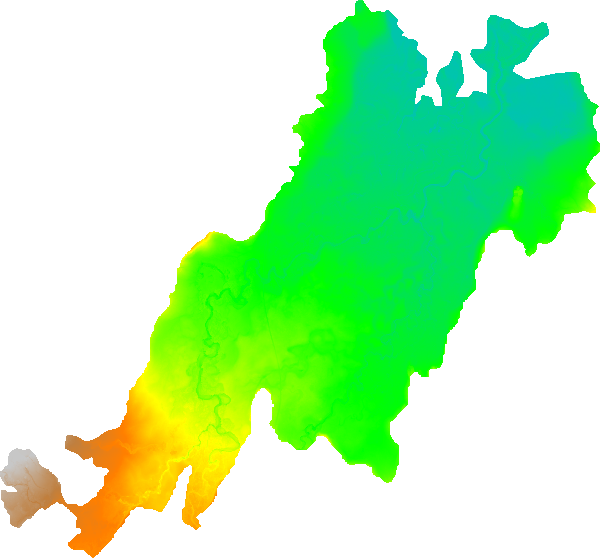

In [12]:
gs.run_command("r.external", input=f"dtm_{name}.tif", output="dtm")
#gs.run_command("r.in.gdal", input="dtm_temp.tif", output="dtm_nofill")
#gs.run_command("r.fill.stats", input="dtm_nofill", distance=8, output="dtm")
gs.run_command("r.colors", map="dtm", color="elevation")

map = gj.Map()
map.d_rast(map='dtm')
map.show()

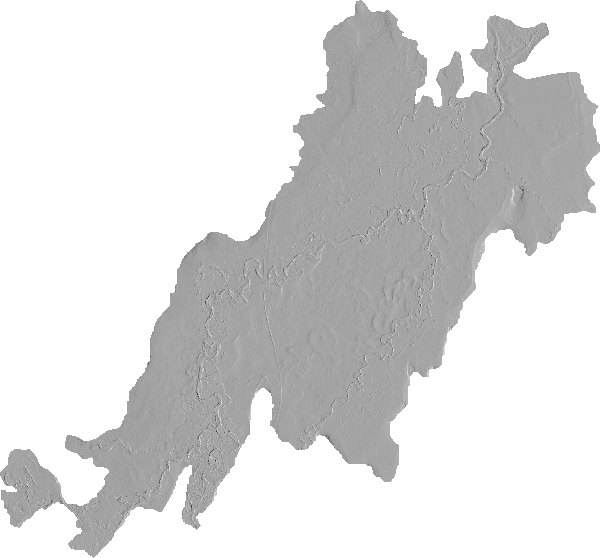

In [13]:
gs.run_command("r.relief", input="dtm", output="dtm_relief")

map = gj.Map()
map.d_rast(map='dtm_relief')
map.show()

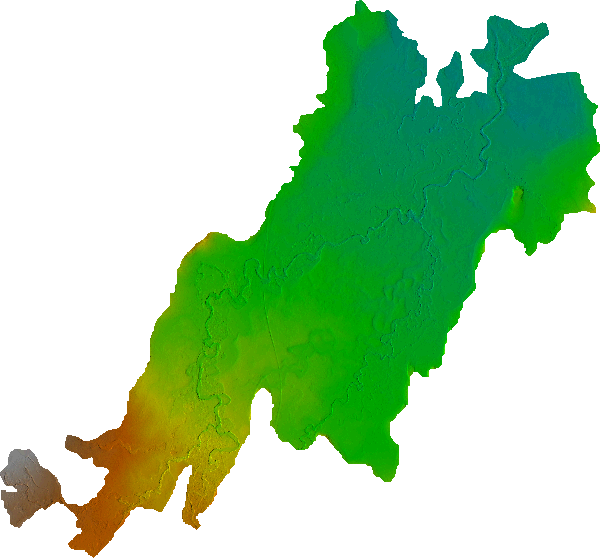

In [14]:
gs.run_command("r.shade", shade="dtm_relief", color="dtm", output="dtm_shade")

map = gj.Map()
map.d_rast(map='dtm_shade')
map.show()

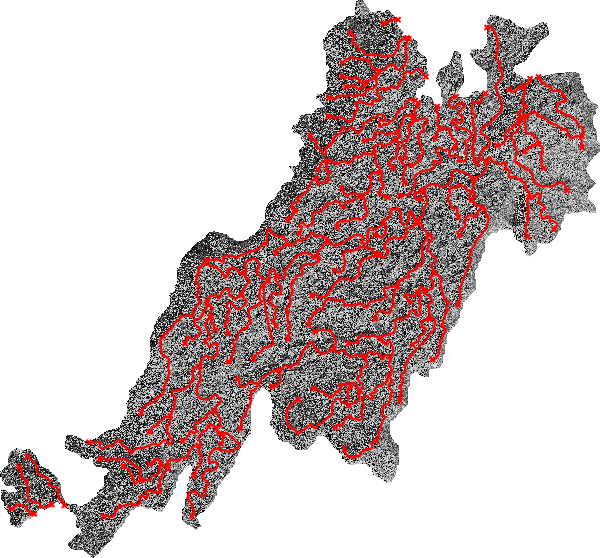

In [15]:
gs.run_command("r.stream.extract", elevation="dtm", threshold=500,
                mexp=0.5, stream_length=500, memory=100000, stream_raster="stream_r",
                direction="direction_r", stream_vector="stream_vect")

map = gj.Map()
map.d_rast(map='direction_r')
map.d_vect(map='stream_vect', color="red", width=2)
map.show()

In [16]:
#gs.run_command("g.extension", extension="r.accumulate")

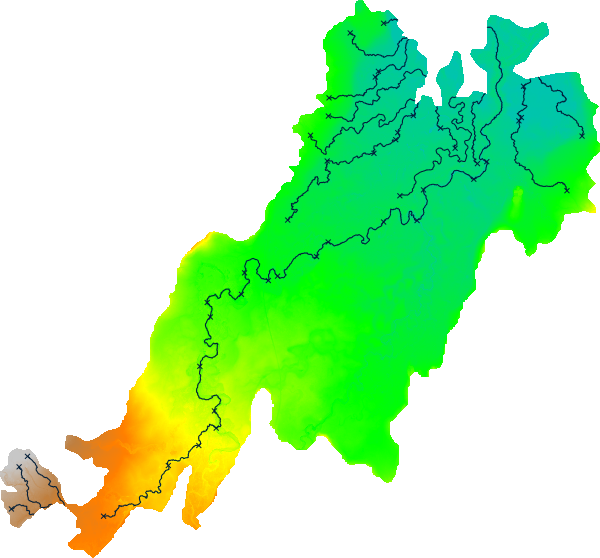

In [17]:
gs.run_command("r.accumulate", direction="direction_r", format="auto", accumulation="accum",
               outlet="stream_vect", longest_flow_path="longest_stream")

gs.run_command("r.stream.order", stream_rast="stream_r", accumulation="accum", direction="direction_r",
                elevation="dtm", hack="stream_hack", stream_vect="stream_v")

# derive main channel
gs.run_command("v.extract", input="stream_v", where='"hack" = 1', output="hack_1_channels")
gs.run_command("v.build.polylines", input="hack_1_channels", output="connected_channels", cats="first")

map = gj.Map()
map.d_rast(map='dtm')
map.d_vect(map='connected_channels')
map.show()

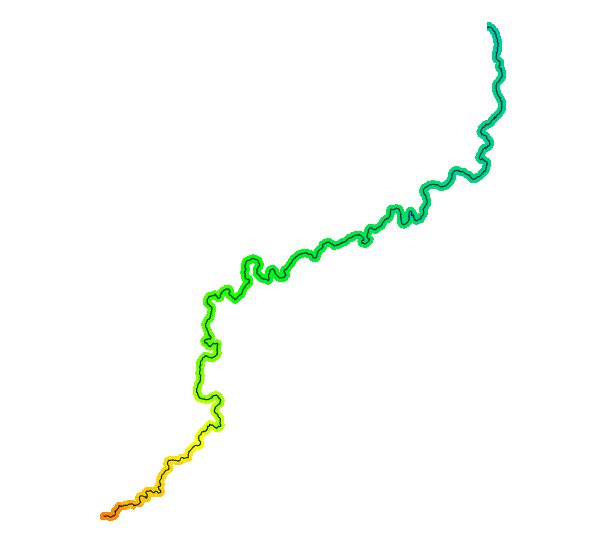

In [74]:
# get longest channel
lengths = gs.read_command("v.to.db", flags="p", map="connected_channels", type="line", option="length", columns="aa", separator=",")
df = pd.read_csv(io.StringIO(lengths))
cat = df.iloc[df['length'].idxmax(), 0]
gs.run_command("v.extract", input="connected_channels", output="longest_channel", cat=cat, type="line")

map = gj.Map()
map.d_rast(map='dtm')
map.d_vect(map='longest_channel')
map.show()

In [75]:
gs.run_command("v.generalize", input="longest_channel", type="line", method="snakes", threshold=1, output="longest_channel_simplified")
#snakes takes ~4min, but I like the results
#other methods take seconds. Is there one as good?
gs.run_command("v.out.ogr", input="longest_channel_simplified", output=f"{name}_main_channel.geojson", format="GeoJSON")

In [76]:
map = gj.InteractiveMap()
map.add_raster(name='dtm_shade')
map.add_vector(name='longest_channel_simplified')
map.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [21]:
t = !v.to.db map=longest_channel_simplified option=sinuous columns=sinuosity -p

sino = t[3].split("|")[1]
sino

'1.81917670968402'

In [77]:
# buffer
gs.run_command("v.buffer", input="longest_channel_simplified", output="channel_buffer", type="line", distance=15)
# activate mask
gs.run_command("r.mask", vector="channel_buffer")
# hand
gs.run_command("r.stream.distance", stream_rast="stream_r", direction="direction_r", elevation="dtm", difference="hand")
# deactivate mask
gs.run_command("r.mask", flags="r")
# reclassify (0:1:1 means values 0-1 will become 1)
#gs.write_command("r.recode", input="hand", output="hand_reclass", rules="-", stdin="\n".join(["-1:0:0", "0:1:1", "1:2:2", "2:3:3"]))
# set specific colors
#gs.write_command("r.colors", map="hand_reclass", rules="-", stdin="\n".join(["0 red", "1 green", "2 blue", "3 yellow"]))
# or simply choose a color ramp
gs.run_command("r.colors", map="hand", color="bcyr")

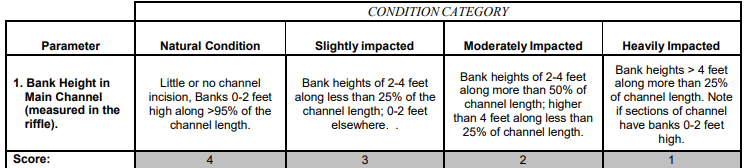

In [78]:
# calculate bank height values using categories from American Rivers
#

In [79]:
gs.run_command("r.geomorphon", forms="forms", elevation="dtm", search=10, skip=3, flat=2.5)

In [80]:
# compute maximum curvature
gs.run_command("r.param.scale", input="dtm", output="maxcurvature", size=7, method="maxic")

In [81]:
gs.run_command("r.mask", vector="channel_buffer")

In [82]:
gs.run_command("v.to.rast", type="line", input="longest_channel_simplified", output="longest_channel_simplified", use="val", flags="d")
# high cost around the start and end point of the stream to not let cost path route around"
high_cost = 100000
gs.run_command("v.to.points", input="longest_channel_simplified", output="longest_channel_simplified_start", use="start")
gs.run_command("v.to.points", input="longest_channel_simplified", output="longest_channel_simplified_end", use="end")
gs.run_command("v.patch", input="longest_channel_simplified_start,longest_channel_simplified_end", output="longest_channel_simplified_start_end")
gs.run_command("v.to.rast", input="longest_channel_simplified_start_end", output="longest_channel_simplified_start_end", type="point", use="val", value=high_cost)
gs.run_command("r.grow", flags="m", input="longest_channel_simplified_start_end", output="longest_channel_simplified_start_end_buffer", radius=10)
baseline_cost = 100
curvature_threshold = 0.95

In [83]:
gs.mapcalc(f"cost = if ( isnull(longest_channel_simplified), if ((1 - maxcurvature) < {curvature_threshold}, 1 - maxcurvature, {baseline_cost}), {high_cost})")
gs.run_command("r.patch", input=["longest_channel_simplified_start_end_buffer", "cost"], output="cost")

# create start and end points for least cost path
category = gs.read_command("v.category", input="longest_channel_simplified", type="line", option="print").strip()
offset = 20
side_offset = 5
gs.write_command("v.segment", input="longest_channel_simplified", output="start_point_right", rules="-", stdin=f"P 1 {category} {offset} {side_offset}")
gs.write_command("v.segment", input="longest_channel_simplified", output="start_point_left", rules="-", stdin=f"P 1 {category} {offset} -{side_offset}")
gs.write_command("v.segment", input="longest_channel_simplified", output="end_point_right", rules="-", stdin=f"P 1 {category} -{offset} {side_offset}")
gs.write_command("v.segment", input="longest_channel_simplified", output="end_point_left", rules="-", stdin=f"P 1 {category} -{offset} -{side_offset}")


In [84]:
gs.run_command("r.cost", flags="k", input="cost", output="cumulative_cost_right", outdir="costdir_right", start_points="start_point_right")
gs.run_command("r.cost", flags="k", input="cost", output="cumulative_cost_left", outdir="costdir_left", start_points="start_point_left")

In [85]:
gs.run_command("r.path", flags="c", input="costdir_right", vector_path="bank_right", raster_path="bank_right", values="hand", start_points="end_point_right")
gs.run_command("r.path", flags="c", input="costdir_left", vector_path="bank_left", raster_path="bank_left", values="hand", start_points="end_point_left")
# reclassify each bank
gs.write_command("r.recode", input="bank_right", output="bank_recode_right", rules="-", stdin="\n".join(["0:0.6:1", "0.6:1.2:2", "1.2:3:3"]))
gs.write_command("r.recode", input="bank_left", output="bank_recode_left", rules="-", stdin="\n".join(["0:0.6:1", "0.6:1.2:2", "1.2:3:3"]))

In [86]:
#!g.extension v.centerline

In [91]:
## compute centerline from right and left banks
gs.run_command("v.patch", input=["bank_left", "bank_right", "longest_channel_simplified"], output="banks")
## fix categories
gs.run_command("v.category", input="banks", output="banks2", option="del")
gs.run_command("v.category", input="banks2", output="banks", option="add")
# get number of vertices for v.centerline - e.g. every 2 meters
lengths = gs.read_command("v.report", map="banks", option="length", flags="c", separator="comma", units="meters").splitlines()
num_vertices = round(float(lengths[0].split(",")[1]) / 2) #+ round(float(lengths[0].split(",")[1]) / 25)#gs.run_command("g.extension", extension="v.centerline")
gs.run_command("v.centerline", input="banks", output="banks_center2", vertices=num_vertices)
gs.run_command("v.category", input="banks_center2", output="banks_center", option="add")

In [92]:
map = gj.InteractiveMap(height=700, width=900)
map.add_raster(name='dtm_shade')
map.add_vector(name='longest_channel_simplified')
map.add_vector(name='bank_right')
map.add_vector(name='banks_center')
map.add_vector(name='bank_left')
map.add_layer_control()
map.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [38]:
num_vertices

2149

In [ ]:
gs.run_command("r.patch", input="bank_recode_right,bank_recode_left", output="banks_recode")
stats_right = gs.read_command("r.stats", input="bank_recode_right", flags="na", separator="comma")
stats_left = gs.read_command("r.stats", input="bank_recode_left", flags="na", separator="comma")
stats_both = gs.read_command("r.stats", input="banks_recode", flags="na", separator="comma")
gs.run_command("r.mask", flags="r")

In [ ]:
df_b = pd.read_csv(io.StringIO(stats_right), names=["category", "area"], index_col=0)
df_b["bank"] = ["0-2 feet", "2-4 feet", "4+ feet"]
df_b["percentage"] = df_b.area/df_b.area.sum() * 100
df_b

### pixels based method using hand model

In [ ]:
# calculate bank height values using categories from American Rivers
#
gs.run_command("r.mask", raster="forms", maskcats=4)
# reclassify (0:1:1 means values 0-1 will become 1)
gs.write_command("r.recode", input="hand", output="hand_recode", rules="-", stdin="\n".join(["0:0.6:1", "0.6:1.2:2", "1.2:3:3"]))
stats = gs.read_command("r.stats", input="hand_recode", flags="na", separator="comma")
gs.run_command("r.mask", flags="r")
df_h = pd.read_csv(io.StringIO(stats), names=["category", "area"], index_col=0)
df_h["bank"] = ["0-2 feet", "2-4 feet", "4+ feet"]
df_h["percentage"] = df_h.area/df_h.area.sum() * 100
df_h

In [ ]:
#map = gj.Map()
#map.d_rast(map='hand_recode')
#map.d_vect(map='plong_simp')
#map.show()

In [ ]:
#!g.extension v.transects

In [ ]:
gs.run_command("r.stream.distance", stream_rast="stream_r", direction="direction_r", elevation="dtm", difference="stream")

gs.run_command("v.transects", input="banks_center", output="transects", dleft=10, dright=10,
               transect_spacing=10, transect_perpendicular="trend", metric="along")
gs.run_command("v.to.points", input="transects", out="points", use="vertex")

result = gs.read_command("v.out.ascii", input="points", separator=",")
df = pd.DataFrame([row.rsplit(',',1) for row in result.splitlines()],
                  columns=["coors","cat"])
df = df.groupby('cat')['coors'].apply(','.join).reset_index()
df = df.astype({'cat':int}).sort_values(by=['cat'], ignore_index=True)
#df

In [ ]:
map = gj.InteractiveMap(height=700, width=900)
map.add_raster(name='dtm_shade')
#map.add_vector(name='longest_channel_simplified', color='red')
#map.add_vector(name='transects', color='purple')
map.add_vector(name='bank_right')
map.add_vector(name='banks_center', color='black', opacity=0.7)
map.add_vector(name='bank_left')
map.show()

In [ ]:
# try setting the altair Y scale with domainMin and domainMax -https://altair-viz.github.io/user_guide/generated/core/altair.Scale.html
# use DTM min and max to set domain scale?

df['color'] = 0
# try using bins, something like df.elevation.min rounded and subtract 1 meter?
widths = []
heights = []
#red_t = []
html = []
fdf = []
fdfval = []
val = []

for index, row in df.iterrows():
    profile = gs.read_command("r.profile", input="dtm",
                              coordinates=(row["coors"]))
    profile_df = pd.DataFrame([row.split() for row in profile.splitlines()],
                              columns=["distance_(m)", "elevation_(m)"]).apply(pd.to_numeric, errors='coerce')
    fdf.append(profile_df)
    w,dl,dr,h,b,ms = stream_metrics(profile_df)
    #print(index,w,dl,dr,h,b)

    if dl != "invalid" and dr !="invalid":
        heights.append(h)
        widths.append(w)
        #if ((w / h) < 6) or (ms > 0.35):
        if h >  0.5:
            if w/h < 4:
                #print(index, (w/h))
            #red_t.append(1)
                df.loc[index,'color'] = 1

            elif w/h < 5.5:
                df.loc[index,'color'] = 2

            elif w/h < 6.5:
                df.loc[index,'color'] = 3

        else:
            #red_t.append(0)
            df.loc[index,'color'] = 0
    else: 
        #red_t.append(2)
        df.loc[index,'color'] = 4

    chart = alt.Chart(profile_df).mark_line().encode(
        alt.X('distance_(m)'),
        #alt.Y('elevation_(m):Q',scale=alt.Scale(zero=False, nice=True))
        #alt.Y('elevation_(m):Q',scale=alt.Scale(domainMin=min_elev,domainMax=max_elev))
        alt.Y('elevation_(m):Q',scale=alt.Scale(domainMin=profile_df['elevation_(m)'].min() - 1,
                                                domainMax=profile_df["elevation_(m)"].max() + 1))
    ).properties(width=650,height=100) #600/100


    bankfull = alt.Chart(pd.DataFrame({'elevation_(m)': [b]})).mark_rule(
                                                            size=1,
                                                            strokeWidth=2,
                                                            strokeCap='butt',
                                                            strokeDash=[4,4],
                                                            color='purple').encode(y='elevation_(m)')
    
    str_l = alt.Chart(pd.DataFrame({'distance_(m)': [dl]})).mark_rule(
                                                            size=1,
                                                            strokeWidth=1,
                                                            strokeCap='butt',
                                                            strokeDash=[2,2],
                                                            color='red').encode(x='distance_(m)')

    str_r = alt.Chart(pd.DataFrame({'distance_(m)': [dr]})).mark_rule(
                                                            size=1,
                                                            strokeWidth=1,
                                                            strokeCap='butt',
                                                            strokeDash=[2,2],
                                                            color='green').encode(x='distance_(m)')

    #test = chart.to_dict()
    #test2 = bankfull.to_dict()
    #vega_lite = folium.VegaLite(line, width='100%',height='100%')
    #if dl == "invalid" or dr == "invalid":
    #    all = chart
    #else:
    #    all = chart + bankfull + str_l + str_r
    all = chart    
    convert = all.to_dict()

    html.append(convert)
    val.append([index,w,dl,dr,h,b,ms])

In [ ]:
df_mc = pd.DataFrame(fdf[0])
#df_mc

## create new stream metrics function using max curvature

In [ ]:
total_width = sum(widths)
avg_width = total_width / len(widths)
print(avg_width)

total_height = sum(heights)
avg_height = total_height / len(heights)
print(avg_height)

In [ ]:
gs.run_command("v.out.ogr", input="transects", output="transects.geojson", format="GeoJSON")

In [ ]:
#gs.run_command("v.out.ogr", input="transects", output="transects.geojson", format="GeoJSON")
trnscts = gpd.read_file('transects.geojson').to_crs(4326)
trnscts['html'] = html
trnscts['color'] = df['color']

In [ ]:
#gs.run_command("r.geomorphon", forms="forms", elevation="dtm", search=10, skip=3, flat=2.5)

In [ ]:
gs.run_command("v.in.ogr", input="meadow_extent.geojson", output="meadow_extent")
meadow_extent = gs.parse_command("g.region", vector="meadow_extent", flags="ucgl")
loc = (float(meadow_extent["center_long"]), float(meadow_extent["center_lat"]))

In [ ]:
import geopandas as gpd
gdf = gpd.read_file('meadow_extent.geojson')
gdf = gdf.to_crs(6339)
latitude = gdf.centroid.y.iloc[0]
longitude = gdf.centroid.x.iloc[0]

In [ ]:
loc = (latitude, longitude)

In [ ]:
def transect_style(color): #change red to color
    if color == 1:
        style = lambda x:{'color':'red','weight':3,'dashArray':"4,8"}
    elif color == 2:
        style = lambda x:{'color':'orange','weight':3,'dashArray':"4,8"}
    elif color == 3:
        style = lambda x:{'color':'yellow','weight':3,'dashArray':"4,8"}
    elif color == 4:
        style = lambda x:{'color':'grey','weight':3,'dashArray':"4,8"}
    else:
        style = lambda x:{'color':'purple','weight':3,'dashArray':"4,8"}
    return style

In [ ]:
m = folium.Map(location=[loc[1], loc[0]], zoom_start=14, max_zoom=21, tiles="OpenStreetMap")

map_title = "Stream Metrics"
title_style = "position:absolute;z-index:10000;left:5vw;top:1vw;color:orange;font-size:16px;font-weight:bold"
metrics1 = f"Sinousity: {round(float(sino),3)}"
metrics2 = f"Width/Depth: {round((avg_width/avg_height),3)}"
metrics3 = "Bank Category:"
metrics4 = f"{df_b.bank.iloc[0]}: {df_b.percentage.iloc[0]:.2f}%"
metrics5 = f"{df_b.bank.iloc[1]}: {df_b.percentage.iloc[1]:.2f}%"
metrics6 = f"{df_b.bank.iloc[2]}: {df_b.percentage.iloc[2]:.2f}%"
metrics_style = "position:absolute;z-index:9000;left:5vw;top:5vw;color:white;font-size:14px"
title_html = f'<p style={metrics_style}>{metrics1}<br>{metrics2}<br>{metrics3}<br>{metrics4}<br>{metrics5}<br>{metrics6}</p><h1 style={title_style}>{map_title}</h1>'
m.get_root().html.add_child(folium.Element(title_html))

#adding USGS logo *does not resize properly
image_usgs = "../USGS.png" #maybe point this to a url?
with open(image_usgs, 'rb') as lf:
   #open in binary mode, read bytes, encode, decode obtained bytes as utf-8 string
   b64_content = base64.b64encode(lf.read()).decode('utf-8') 
FloatImage('data:image/png;base64,{}'.format(b64_content), bottom=0, left=0, width='8%',height='7%').add_to(m)

# Adding my_custom_style to the map
#m.get_root().add_child(my_custom_style)



gj.Raster('dtm_shade',show=False).add_to(m) #DTM causing Folium to not save map. Can't convert to HTML string?
gj.Raster('forms','geomorphons', opacity=0.7,show=False).add_to(m)
gj.Raster('hand',show=False, opacity=0.7).add_to(m) 
gj.Raster('hand_recode',show=False, opacity=0.7).add_to(m) 
gj.Vector('longest_channel_simplified','main channel').add_to(m)
gj.Vector('bank_right','right bank',color='black',opacity=0.5).add_to(m)
gj.Vector('bank_left','left bank',color='black',opacity=0.5).add_to(m)
#gj.Vector('meadow_extent', show=False, color='red', fill=False).add_to(m)

fg =folium.FeatureGroup(name='Transects').add_to(m)
for _, s in trnscts.iterrows():
    graph = s['html']
    coords = list(s['geometry'].coords)
    ttip = s['cat']

    geo_data={"type":"Polygon","coordinates":[coords]}
    geo_obj=folium.GeoJson(geo_data, style_function=transect_style(s['color']),
                            highlight_function=lambda x:{'color':'yellow','weight':8},
                            opacity=0.7,
                            tooltip=folium.Tooltip(ttip),
                            popup=folium.Popup().add_child(folium.VegaLite(graph,width="100%")),
                            #popup_anchor=(0,40),
                            popup_keep_highlighted=True, #needs python 3.9?
                            )
    #geo_obj.add_child(folium.Popup(max_width=650).add_child(folium.VegaLite(graph)))
    geo_obj.add_to(fg)    
m.add_child(folium.LayerControl())
m.add_child(MeasureControl())

In [ ]:
m.save('stream_metrics.html')

In [ ]:
print(f'Purple = {sum(trnscts.color == 0)}, {sum(trnscts.color == 0)/len(trnscts)*100}')
print(f'Red = {sum(trnscts.color == 1)}')
print(f'Orange = {sum(trnscts.color == 2)}')
print(f'Yellow = {sum(trnscts.color == 3)}')
print(f'Grey = {sum(trnscts.color == 4)}')

print(f'Total = {len(trnscts)}')

## GEE API to access NAIP
  
*requires authentication

https://code.earthengine.google.com/f8abc4170159ea17ba74f11a67f8a4ee

In [ ]:
from folium.plugins import MeasureControl, FloatImage
from matplotlib.pyplot import text
from samgeo import SamGeo
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import datetime
import base64
import folium 
import geemap
import json
import sys
import os
import ee

print(f"geopandas version:{gpd.__version__}")
print(f"pandas version:{pd.__version__}")
print(f"folium version:{folium.__version__}")
print(f"python version:{sys.version[:6]}")
print(f"ee version:{ee.__version__}")

In [ ]:
# token will need to be updated occassionaly (time sensitive) 
# can the token be cached?

#use (force=True) to reset
ee.Authenticate()

In [ ]:
# Initialize Earth Engine
ee.Initialize()

In [ ]:
fp_aoi = 'meadow_extent.geojson'

In [ ]:
gdf = gpd.read_file(fp_aoi)
gdf

In [ ]:
gdf.to_crs('epsg:4326', inplace=True)

In [ ]:
bbox = gdf.bounds.values.tolist().pop()
bbox

In [ ]:
bounds = [[bbox[1], bbox[0]], [bbox[3], bbox[2]]]

In [ ]:
aoi = geemap.gdf_to_ee(gdf)

In [ ]:
Map = geemap.Map()
#point = ee.Geometry.Point(-122.259679, 37.871838)
collection = (
    ee.ImageCollection("USDA/NAIP/DOQQ")
    .filterBounds(aoi)
    .filterDate("2022-01-01", "2023-01-01")
    .filter(ee.Filter.listContains("system:band_names", "N"))
)
image = collection.first()
Map.addLayer(image, {}, "NAIP")
Map.centerObject(aoi, 16)
Map

In [ ]:
bbox = Map.user_roi_coords()
if bbox is None:
    bbox = [-122.2666, 37.8682, -122.252, 37.8752]

In [ ]:
geemap.ee_to_geotiff(
    image, "naip_NRB.tif", bbox, resolution=0.6, vis_params={"bands": ["N", "R", "B"]}
)

In [ ]:
geemap.ee_export_image(
    image, "naip_06.tif", scale=0.6, region=bbox, file_per_band=False,
)

In [ ]:
m = folium.Map(location=[loc[1], loc[0]], zoom_start=14, max_zoom=21, tiles="OpenStreetMap")

map_title = "Stream Metrics"
title_style = "position:absolute;z-index:10000;left:5vw;top:1vw;color:orange;font-size:16px;font-weight:bold"
metrics1 = f"Sinousity: {round(float(sino),3)}"
metrics2 = f"Width/Depth: {round((avg_width/avg_height),3)}"
metrics3 = "Bank Category:"
metrics4 = f"{df_b.bank.iloc[0]}: {df_b.percentage.iloc[0]:.2f}%"
metrics5 = f"{df_b.bank.iloc[1]}: {df_b.percentage.iloc[1]:.2f}%"
metrics6 = f"{df_b.bank.iloc[2]}: {df_b.percentage.iloc[2]:.2f}%"
metrics_style = "position:absolute;z-index:9000;left:5vw;top:5vw;color:white;font-size:14px"
title_html = f'<p style={metrics_style}>{metrics1}<br>{metrics2}<br>{metrics3}<br>{metrics4}<br>{metrics5}<br>{metrics6}</p><h1 style={title_style}>{map_title}</h1>'
m.get_root().html.add_child(folium.Element(title_html))

#adding USGS logo *does not resize properly
image_usgs = "data\\USGS.png" #maybe point this to a url?
with open(image_usgs, 'rb') as lf:
   #open in binary mode, read bytes, encode, decode obtained bytes as utf-8 string
   b64_content = base64.b64encode(lf.read()).decode('utf-8') 
FloatImage('data:image/png;base64,{}'.format(b64_content), bottom=0, left=0, width='8%',height='7%').add_to(m)

# Adding my_custom_style to the map
#m.get_root().add_child(my_custom_style)

image_overlay = folium.raster_layers.ImageOverlay(
    image=np.transpose(image, (1, 2, 0)),
    bounds=bounds,
    opacity=0.7,  # Adjust opacity as needed
    interactive=True,
    cross_origin=False,
    zindex=1,
    name="NAIP RGB"
)
image_overlay.add_to(m)


gj.Raster('dtm_shade',show=False).add_to(m) #DTM causing Folium to not save map. Can't convert to HTML string?
gj.Raster('forms','geomorphons', opacity=0.7,show=False).add_to(m)
gj.Raster('hand',show=False, opacity=0.7).add_to(m) 
gj.Raster('hand_recode',show=False, opacity=0.7).add_to(m) 
gj.Vector('plong_simp','main channel').add_to(m)
gj.Vector('bank_right','right bank',color='black',opacity=0.5).add_to(m)
gj.Vector('bank_left','left bank',color='black',opacity=0.5).add_to(m)
gj.Vector(
          'meadow_extent',
          show=False,
          color='red',
          fill=False
          ).add_to(m)

fg =folium.FeatureGroup(name='Transects').add_to(m)
for _, s in trnscts.iterrows():
    graph = s['html']
    coords = list(s['geometry'].coords)
    ttip = s['cat']

    geo_data={"type":"Polygon","coordinates":[coords]}
    geo_obj=folium.GeoJson(geo_data, style_function=transect_style(s['color']),
                            highlight_function=lambda x:{'color':'yellow','weight':8},
                            opacity=0.7,
                            tooltip=folium.Tooltip(ttip),
                            popup=folium.Popup().add_child(folium.VegaLite(graph,width="100%")),
                            #popup_anchor=(0,40),
                            popup_keep_highlighted=True, #needs python 3.9?
                            )
    #geo_obj.add_child(folium.Popup(max_width=650).add_child(folium.VegaLite(graph)))
    geo_obj.add_to(fg)    
m.add_child(folium.LayerControl())
m.add_child(MeasureControl())

# need a function to use only where datasets overlap

In [ ]:

import rasterio
from rasterio.windows import from_bounds
from rasterio.coords import BoundingBox
import numpy as np

def get_overlap_bounds(bounds1, bounds2):
    """Calculate the overlapping bounding box between two rasters."""
    left = max(bounds1.left, bounds2.left)
    bottom = max(bounds1.bottom, bounds2.bottom)
    right = min(bounds1.right, bounds2.right)
    top = min(bounds1.top, bounds2.top)

    if left < right and bottom < top:
        return BoundingBox(left, bottom, right, top)
    else:
        raise ValueError("No overlapping area between rasters.")

def read_and_clip(path, overlap_bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*overlap_bounds, transform=src.transform)
        data = src.read(1, window=window)
        transform = src.window_transform(window)
        profile = src.profile
        profile.update({
            "height": data.shape[0],
            "width": data.shape[1],
            "transform": transform
        })
    return data, profile


In [ ]:
import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
import numpy as np

def get_overlap_bounds(bounds1, bounds2):
    """Calculate the overlapping bounding box between two rasters."""
    left = max(bounds1.left, bounds2.left)
    bottom = max(bounds1.bottom, bounds2.bottom)
    right = min(bounds1.right, bounds2.right)
    top = min(bounds1.top, bounds2.top)

    if left < right and bottom < top:
        return (left, bottom, right, top)
    else:
        raise ValueError("No overlapping area between rasters.")

def get_resolution(transform):
    """Get pixel size from affine transform."""
    return abs(transform.a), abs(transform.e)

def read_and_clip_resample(path, overlap_bounds, target_res):
    with rasterio.open(path) as src:
        window = from_bounds(*overlap_bounds, transform=src.transform)
        transform = src.window_transform(window)

        # Calculate new dimensions
        width = int((overlap_bounds[2] - overlap_bounds[0]) / target_res[0])
        height = int((overlap_bounds[3] - overlap_bounds[1]) / target_res[1])

        # Read and resample
        data = src.read(
            1,
            window=window,
            out_shape=(height, width),
            resampling=Resampling.bilinear
        )

        new_transform = rasterio.transform.from_origin(
            overlap_bounds[0], overlap_bounds[3], target_res[0], target_res[1]
        )

        profile = src.profile
        profile.update({
            "height": height,
            "width": width,
            "transform": new_transform
        })

    return data, profile

# File paths
raster1_path = "dsm.tif"
raster2_path = "dtm.tif"

# Open both rasters to get bounds and resolutions
with rasterio.open(raster1_path) as r1, rasterio.open(raster2_path) as r2:
    bounds1 = r1.bounds
    bounds2 = r2.bounds
    res1 = get_resolution(r1.transform)
    res2 = get_resolution(r2.transform)

    # Determine finer resolution
    target_res = (min(res1[0], res2[0]), min(res1[1], res2[1]))

    # Get overlapping bounds
    overlap_bounds = get_overlap_bounds(bounds1, bounds2)

# Clip and resample both rasters
raster1_data, profile1 = read_and_clip_resample(raster1_path, overlap_bounds, target_res)
raster2_data, profile2 = read_and_clip_resample(raster2_path, overlap_bounds, target_res)

# Optional: Save outputs
with rasterio.open("raster1_clipped_resampled.tif", "w", **profile1) as dst:
    dst.write(raster1_data, 1)

with rasterio.open("raster2_clipped_resampled.tif", "w", **profile2) as dst:
    dst.write(raster2_data, 1)


In [ ]:

# Paths to your rasters
raster1_path = "dsm.tif"
raster2_path = "dtm.tif"

# Open both rasters to get bounds
with rasterio.open(raster1_path) as r1, rasterio.open(raster2_path) as r2:
    bounds1 = r1.bounds
    bounds2 = r2.bounds
    overlap_bounds = get_overlap_bounds(bounds1, bounds2)

# Clip both rasters to the overlapping area
raster1_clipped, profile1 = read_and_clip(raster1_path, overlap_bounds)
raster2_clipped, profile2 = read_and_clip(raster2_path, overlap_bounds)

# Optional: Save clipped rasters
with rasterio.open("raster1_clipped.tif", "w", **profile1) as dst:
    dst.write(raster1_clipped, 1)

with rasterio.open("raster2_clipped.tif", "w", **profile2) as dst:
    dst.write(raster2_clipped, 1)


In [ ]:
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds

# Get bounds from naip_profile
naip_transform = naip_profile['transform']
naip_width = naip_profile['width']
naip_height = naip_profile['height']
naip_crs = naip_profile['crs']

# Calculate bounds of naip
left = naip_transform.c
top = naip_transform.f
right = left + naip_transform.a * naip_width
bottom = top + naip_transform.e * naip_height

# Open brightness raster and crop to naip bounds
with rio.open(chm_path) as src_chm:
    # Reproject bounds if needed
    if src_chm.crs != naip_crs:
        bounds = transform_bounds(naip_crs, src_chm.crs, left, bottom, right, top)
    else:
        bounds = (left, bottom, right, top)
    window = from_bounds(*bounds, src_chm.transform)
    chm_cropped = src_chm.read(window=window)

In [ ]:
chm_cropped = chm_cropped[0]

In [ ]:
chm_cropped.shape

In [ ]:
naip.shape

In [ ]:
from rasterio.enums import Resampling
# Get shape of chm_cropped
target_height, target_width = chm_cropped.shape[1], chm_cropped.shape[2]

# Resample dep to match chm_cropped shape
with rio.open(out_ero) as src_ero:
    ero_resampled = src_ero.read(
        out_shape=(src_ero.count, target_height, target_width),
        resampling=Resampling.bilinear
    )